# Data center hash code 2015

In [1]:
# importing dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Reading data 

In [2]:
os.chdir('D:/Downloads/')   # put the path to the data 
data = pd.read_csv('dc.in', sep = ' ' ,index_col=False)
data.head()

,16,100,80,45,625
0,10,23,NaN,NaN,NaN
1,0,40,NaN,NaN,NaN
2,4,40,NaN,NaN,NaN
3,3,57,NaN,NaN,NaN
4,11,78,NaN,NaN,NaN


In [3]:
# getting important parameters 
params = list(data.columns)  # list of parameters


rows_number = int(params[0])
spots_number = int(params[1])  # number of spots in each row 
number_unavailable_spots = int(params[2])  # this is contain informations about the unavailale spots as a pair of 2 numbers ri and si where ri is the row number and si is the spot position in that row 
number_pools = int(params[3])
number_servers = int(params[4])  # a server is a pair of (zi,ci) where zi is the size of the server and ci is the capacity of the server


# Let's do some analysis to have an overview of the problem

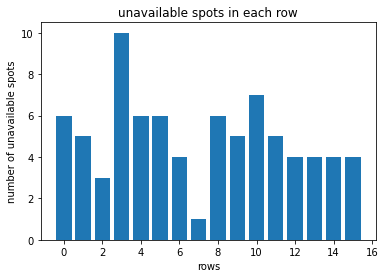

In [4]:
# let's see the distribution of the unavailable spots over rows 
t={}
m=sorted(data['16'].values[:number_unavailable_spots])
for i in np.unique(m):
    t[i] = m.count(i)
    
plt.bar(list(t.keys()), list(t.values()))
plt.title('unavailable spots in each row')
plt.xlabel('rows')
plt.ylabel('number of unavailable spots')
plt.show()

* there is about 4 unavailable spots in each row

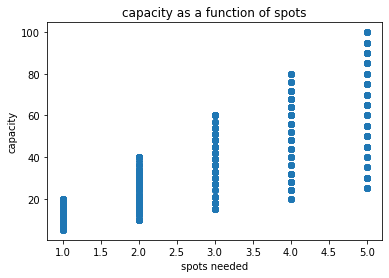

In [5]:
#let's see if there is a correlation between the number of required spots and the capacity of a giving server 

serv_dict = {}
tt = data['16'].values[number_unavailable_spots:]
mm = data['100'].values[number_unavailable_spots:]

plt.scatter(tt,mm)
plt.xlabel('spots needed')
plt.ylabel("capacity")
plt.title('capacity as a function of spots')
plt.show()

* **Conclusion:** there is no correlation between the number of spots needed and the capacity of the servers: e.g a server may require 5 spots and provide less capacity than another one that only requires 3 spots. So we should sort servers according to their real capacity = $\frac{capacity}{spots needed}$

# Now let's find a suitable representation of the data

we will represent our data as follows:
* **servers:** a dictionnary with as keys the index of the servers in the original matrix and as values the pair of the size and capacity defining each server. 
* **rows:** a 100-d vector with the available spots on it, and another matrix **visited_rows** to help us to know if a spot has been visited by our algorithm or not yet.
* **pools:** a dictionnary of pools and the list of index of servers associated to each pool
* **result_server**: to save the results in the required format.


In [6]:
data = data.values
data = data[:,:2].astype(int)

# About servers 

# a dictionnary that associates to each server the row and the spot where it will be allocated
result_server = {}  
#  a dictionnary that represent a server by its index and map it to its number of spots needed and its capacity 
servers = {}  
for i in range(number_unavailable_spots, len(data)):
    servers[i] = data[i]
    result_server[i] = None
 
 
# row matrix : 1 if the spot is unavailable and 0 if not

rows = np.zeros((rows_number , spots_number))
for i in range(number_unavailable_spots):
    rows[data[i][0]][data[i][1]] = 1
    
    



# indicats if a spot has been visited or not yet 

visited_rows = np.zeros((rows_number , spots_number))  # 0 if the spot has not been visited yet and 1 if not and we will extend it so the unavailable spots will be represented by -1.
for i in range(number_unavailable_spots):
    visited_rows[data[i][0]][data[i][1]] = -1

# pools: a dictionnary: the index of the pool and the index of servers on that pool
pools = {}
for i in range(number_pools):
    pools[i]  = []

# Initialization:

### Useful functions

In [7]:
# a function to find the index of a server on the list servers_real_capacity_sorted  (see bellow to understand )
def find_server_index(list_,server):
    list_ = np.array(list_)
    xx = list(list_[:,0])
    return xx.index(server[0])

def find_server_index1 (list_, server): # a server here is refered to just by its index
    list_ = np.array(list_)
    xx = list(list_[:,0])
    return xx.index(server)

def score(server):   # to compute the real capacity of a server 
    # server here is defined by it's size and capcity
    return server[1]/server[0]


# sorting the servers by their real capacity 
servers_real_capacity_sorted = list(reversed(sorted(list(servers.items()) , key = lambda x:score(x[1]))))
servers_real_capacity_sorted_ref = np.copy(servers_real_capacity_sorted) # we keep a copy of the original list 

#we define a function to try to put a server on a row 
def put_server_on_row(server, row_index, process =False):
    global servers_real_capacity_sorted
    # I add process parameter here so that, depending on the goal if it is just to know the available spot where to put the server or to put it and update all the parameters
    nonvisited_spot = list(visited_rows[row_index]).index(0)  # find the first non visited spot 
    # so we will start our research from that spot 
    available_spot = 0 # we will start looking for the available spot
    for i in range(nonvisited_spot, len(rows[row_index])):
        if rows[row_index][i] == 0: # if it is available 
            available_spot = i
            break
    
    # let's try to fill that available spot 
    for j in range(server[1][0]):  #server here is defined as a list [spots needed, capacity]
        if available_spot+j == len(rows[0]):
            return False
        if rows[row_index][available_spot+j] == 1: # to be able to put it we should have all the spots needed to be available
            return False #not able to put it from that spot 
    if process == True:    
        rows[row_index][available_spot:available_spot + server[1][0]] = 1 # update row matrix
        visited_rows[row_index][available_spot : available_spot + server[1][0]] = 1  # update visited matrix 
        if available_spot + server[1][0] < len(visited_rows[0]):
            if visited_rows[row_index][available_spot + server[1][0]] == -1: # this will help me for the next steps, it check if the next spot is unavailable and mark it to 1 as a visited spot
                visited_rows[row_index][available_spot + server[1][0]] = 1
        servers_real_capacity_sorted = np.delete(servers_real_capacity_sorted, find_server_index(servers_real_capacity_sorted ,server), 0)   # update servers

    return available_spot # this is the spot index where we can put the server 

C:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


**Let's take a break from coding and try to understand the idea of our optimization process**
* **useful information:**
    * We will go through each line and try to fill it with servers. The basic idea is that we should ensure diversity so that when a line goes down the effect will be distributed to the maximum possible number of the pools and not only to one pool.
    * Each time a server will be implemented to a given row and associated to a given pool and then we move on to the next pool and next row. When we will run out of rows we will invert the order so that not only the first rows will always have the servers with the highest capacity.
* **Initialization steps:**
    * **The first initialization step:** this first step is as described above.But at this stage all the pools still have 0 garanted capacity.
    * **The second initialization step:** we should be more careful for this step to avoid that a pool contains two servers in the same row. And to assure that not only the first rows will always have the "best" servers in terms of real capacity. 

In [8]:
# a function that do the process of putting a server into a row
def process(row_index, update = False):
    # for simplicity of the algorithme I will start from the second row
    if np.all (visited_rows[row_index]) ==1: # if all the spots have been visited then we should stop processing this row
        return False  
    server_index = 0
    while (server_index < len(servers_real_capacity_sorted) and str(put_server_on_row(servers_real_capacity_sorted[server_index], row_index))== 'False' ) :  # str is because for the algorithme 0 is the same as False 
        # since we still have servers available and we still not be able to put them in that row we will try another server
        server_index +=1 # we will look for another index that might be suitable
        
    
    # so at the end of the loop we will eighter have the server server_index to put into the line rows[i] or we won't
    if server_index == len(servers_real_capacity_sorted): # no server is suitable for this row then we will see if we can put it after the unavailable spot 
        
        # try to find an available spot 
        try:
            nonvisited_spot = list(visited_rows[row_index]).index(0)  # find the first non visited spot 
        except:
            return False  # no available spot
        
        # try to find an unavailable spot 
        try:
            unavailable_spot = list(visited_rows[row_index]).index(-1) # find the first unavailable spot not yet visited
        except:
            visited_rows[row_index][nonvisited_spot:-1] = 1
            return False # because at this stage we're donne with all the spots of this row
        
        assert (unavailable_spot - nonvisited_spot)<5 # assert that the differnce between these two spots is bellow 5 otherwise we made some errors because the mximum spots needed is 5
        visited_rows[row_index][nonvisited_spot:unavailable_spot+1] = 1 # mark these spots unavailable and move to the next available spot after that one
        # let's retry again 
        process(row_index)
    else: # else we can then put it in the right place
        # server_index here is the index of the server in servers_real_capacity_sorted
        server_index_real = servers_real_capacity_sorted[server_index][0]
        spot_index = put_server_on_row(servers_real_capacity_sorted[server_index], row_index, update)
        # rows , visited_rows and servers_real_capacity_sorted are already updated i just need to update the result
        return spot_index, server_index_real  # return the index of the spot and the index of the server 

In [9]:
# First step 
#intialization:
row_index=0  # rows 
pool_index= 0 # pools
server_index = 0 #servers
reverse = False # to tell the direction of the loop for rows if we're going from up to down or from down to up
for pool_index in range(number_pools):  # the initialization will be for all the pools and just once.
    # for simplicity of the algorithm I will start from the first row
    spot_index,server_result = process(row_index, True)
    
    # update the pools and the results 
    
    
    result_server[server_result] = (row_index , spot_index, pool_index) # update result dictionnary
    pools[pool_index].append(server_result)  # update the pools
    if reverse == False:
        row_index +=1
    elif reverse == True:
        row_index -=1
    if row_index == 0:
        row_index = len(rows)-1
        reverse = True
    elif row_index == len(rows):
        row_index = 0
        reverse = False

C:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [10]:
# second step 
# i should added a function to ckeck if a row already contain a server that belongs to a pool already in it or not 
def exist(row_index, pool_index):
    server_index = pools[pool_index][0]
    server_row = result_server[server_index][0]
    if row_index == server_row:
        return True  # true if the first row is already on that row 
    else:
        return False
    
    
row_index=len(rows)-1  # rows  ## this time I'm starting from the last row 
pool_index= 0 # pools
server_index = 0 #servers
reverse = True # the direction of the loop for rows if we're going from up to down or from down to up
for pool_index in range(number_pools):  # the initialization will be for all the pools and just once.
    
    
    if exist(row_index, pool_index):
        if reverse == False:
            row_index +=1
        elif reverse == True:
            row_index -=1
    spot_index,server_result = process(row_index, True)
    
    # update the pools and the results
    result_server[server_result] = (row_index , spot_index, pool_index) # update result dictionnary
    pools[pool_index].append(server_result)  # update the pools
    if reverse == False:
        row_index +=1
    elif reverse == True:
        row_index -=1
    if row_index == 0:
        row_index = len(rows)-1
        reverse = True
    elif row_index == len(rows):
        row_index = 0
        reverse = False

* **So our algorithm is working let's now continue the work and optimize it** 

# Optimization:

### At this stage we already have all the pools perfectly initialized we still need to define some functions to help us do the optimization process 
* Define a function or a data structure that will help us to **calculate the guaranteed capacity** of a giving pool and sort them by capacity to determine the weakest pool in terms of guaranteed capacity and then work on that pool.
* **Processing the weakest pool:** this is the important point where we are going to optimize the weakest pool, to do so we are going to look for the weakest row and try to insert a new server and then check if it still the weakest row in the weakest pool, if yes we will repeat the process on the same pool otherwise we are going to look for another pool.

In [12]:
# optimization:
def guaranteed_capacity_map(pool_index):
    # this is a function to calculate the guaranteed capacity per row of a giving pool
    # pool index is the index of the giving pool
    servers_index = pools[pool_index]
    # we need the capacity and the ligne where this capacity is located 
    capacity_per_row = {}
    for i in range(len(rows)):
        capacity_per_row[i] = 0
    for server_index in servers_index:
        #we will forst get the row_index of each server
        server_row = result_server[server_index][0] # reminder: an instance of result_server is a tuple (row_index , spot_index, pool_index)
        # after that we look for the capacity of the server
        # loookig for server capacity
        server_capacity = servers[server_index][1]
        #server_capacity = servers_real_capacity_sorted_ref[find_server_index1(servers_real_capacity_sorted_ref,server_index)][1][1] # reminder: a server is defined as a tuple: (index, [spots needed, capacity])
        capacity_per_row [server_row] += server_capacity
    return capacity_per_row

# a function to compute the guaranteed capacity of a pool

def guaranteed_capacity (pool_index):
    capacity_per_row = guaranteed_capacity_map (pool_index)
    return sum(list(capacity_per_row.values())) - max(list(capacity_per_row.values())) # the definition of the guaranteed capacity of a giving row

# a function to find the weakest pool
def weakest_pool_finder():
    # pool index and it's capacity
    capacities_per_pool = [(pool_index, guaranteed_capacity (pool_index)) for pool_index in range(number_pools)] 
    # find the min and return it's index
    # we sort it regarding it's capacity and then we look for the weakest pool
    tt = [x[1] for x in capacities_per_pool] # list to find the index of the weakest pool by its capacity
    index_ = np.argmin(tt)
    return capacities_per_pool[index_][0] # the index of the weakest pool 
    

In [13]:
# Now let's just optimize

while np.any(visited_rows != 1):
    
    pool_index = weakest_pool_finder()   #find the weakest pool
    #print(guaranteed_capacity(pool_index))
    pool_map = guaranteed_capacity_map(pool_index) #a dictionnary map that will help us to find the weakest row of that pool
    pool_map = sorted(list(pool_map.items()) , key = lambda x:x[1])  # sorting the map according to the capacity per row
    weakest_row_index = 0
    while weakest_row_index < len(pool_map):
        processed = process(pool_map[weakest_row_index][0])
        if processed == False:   # we move to the next row  
            weakest_row_index +=1
        else:
            break
    #print(weakest_row_index)
    if weakest_row_index == len(pool_map): # which mean that the optimization is done 
        break
    #if weakest_row_index 
    else:        
            #else:  # we should update ### but first let's think about the scenario when adding a server will just make it worst (nvm: no need)
        
        spot_index, server_index = process(pool_map[weakest_row_index][0])
        # let's try to make updates on the pool and see its performance
    #             new_capacity_map = np.copy(aranteed_capacity_map(pool_index))
    #             new_capacity_map[weakest_row] += servers[server_index][]
    #             new_pool_capacity = sum(list(new_capacity_map.values())) - max(list(new_capacity_map.values()))
    #             old_pool_capacity = guaranteed_capacity (pool_index)
    #             if new_pool_capacity > old_pool_capacity: # if this is true then we're going to put that server on that pool otherwise we're not
        spot_index, server_index = process(pool_map[weakest_row_index][0], True)
            # one final step is to associate the server to the pool
        pools[pool_index].append(server_index)
            # updating results 
        result_server[server_index] = (pool_map[weakest_row_index][0] , spot_index, pool_index)
        # I changed the algorithme so that it will process anyways  
        #print(visited_rows[weakest_row_index], 'finished')
        

# Let's see our score:

In [14]:
print('The score of this strategy is: ', guaranteed_capacity(weakest_pool_finder()) )

The score of this strategy is:  378


# Time to do some analysis: 

The highest score achieved so far for this competition was 407 let's see if we can do better.
* We have no interest in maximizing the other pools, so let's see the capacity of the strongest pool and try to modify it and add some servers to the weekest pool.Let's also try to see the distribution of guaranteed capacity and the number of servers for each pool

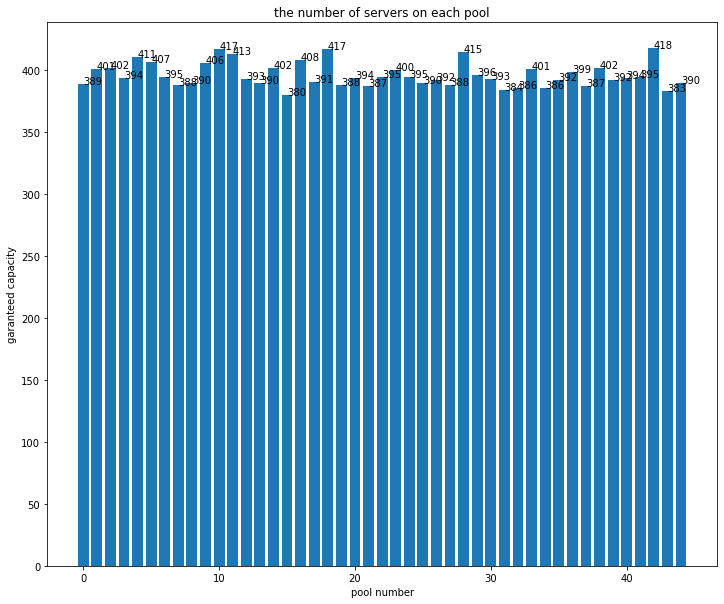

In [40]:
# the guaranteed capacity of each pool
plt.figure(figsize= (12,10))
plt.bar(list(pools.keys()), [guaranteed_capacity(i) for i in pools.keys()])
plt.title('the number of servers on each pool')
plt.xlabel('pool number')
plt.ylabel('guaranteed capacity')
for j in range(len(list(pools.keys()))):
    plt.text(j, guaranteed_capacity(j) , guaranteed_capacity(j))

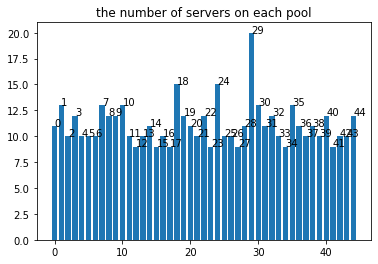

In [18]:
#the number of servers on each pool
# Let's try to swap the servers between rows or between pools, for that i need to see the distribution of the servers among these parameters
plt.bar(list(pools.keys()), [len(pools[i]) for i in pools.keys()])
plt.xlabel('pool number')
plt.ylabel('number of servers')
for j in range(len(list(pools.keys()))):
    plt.text(j, len(pools[j]), j)
plt.title('the number of servers on each pool')
plt.show()

In [19]:
# let's see why pool 29 have the highest number of servers and still the weakest one:
guaranteed_capacity_map_ = guaranteed_capacity_map(29)
guaranteed_capacity_map_

{0: 72,
 1: 0,
 2: 16,
 3: 32,
 4: 60,
 5: 0,
 6: 42,
 7: 0,
 8: 26,
 9: 60,
 10: 0,
 11: 0,
 12: 50,
 13: 20,
 14: 0,
 15: 274}

# Based on these graphs let's think about the strategy we are going to use:
* the pool 29 has umbalanced distribution of servers over rows, let's elaborate a strategy to remedy this.
* As before we are going to find the weakest row of the weakest pool, and then for that row we are going to check if it is possible to take one server from a stronger server and associate it to this pool.
* Another way to do this is: For each row we look for the pool with the highest capacity and we try to take some servers from it and associate it to the weakest one. (We adopt this it seems more effecient) [ better than that I'll try to combine them]

### We will look for the weakest pool and it's weakest row and then do the swap

0 90


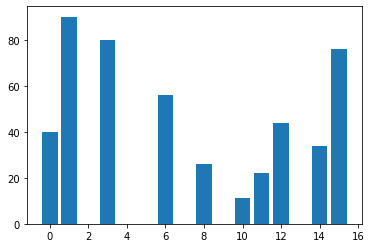

0 60


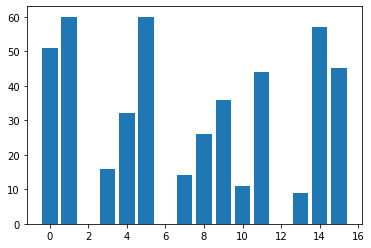

0 95


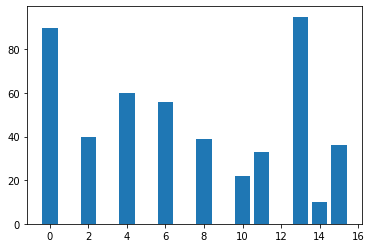

0 90


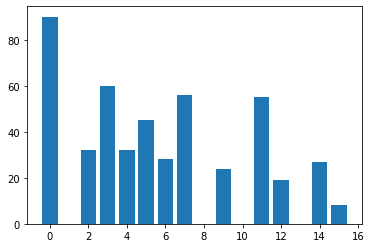

0 90


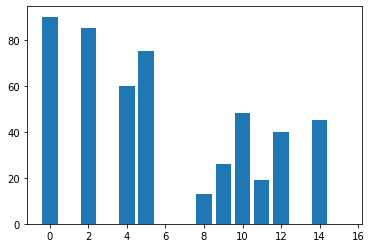

0 68


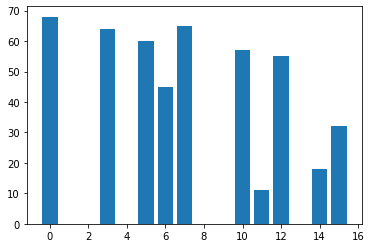

0 95


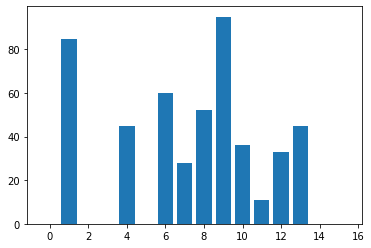

0 80


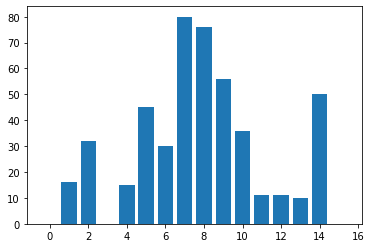

0 100


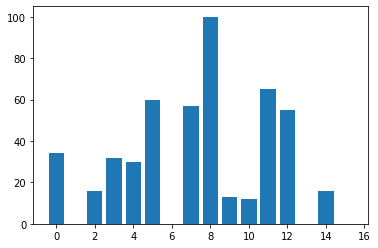

0 75


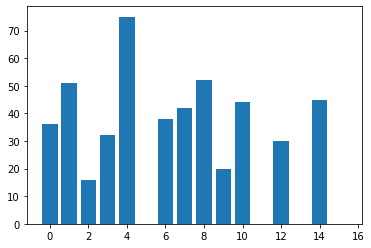

0 90


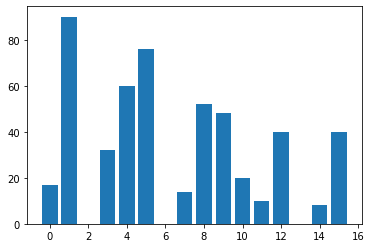

0 85


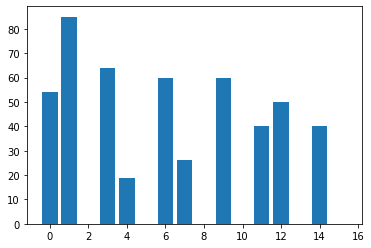

0 70


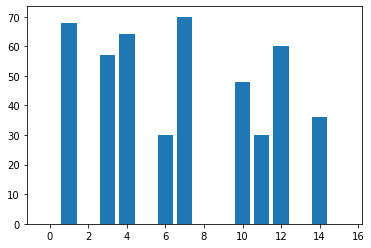

0 100


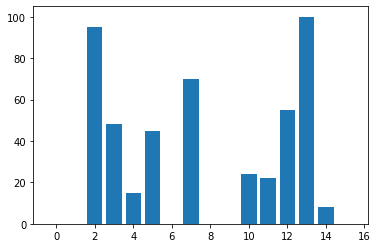

0 90


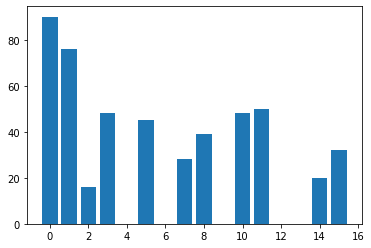

0 100


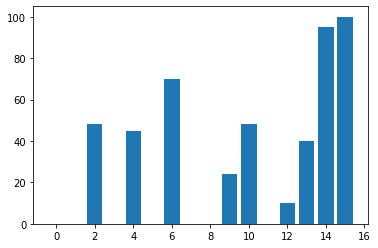

0 95


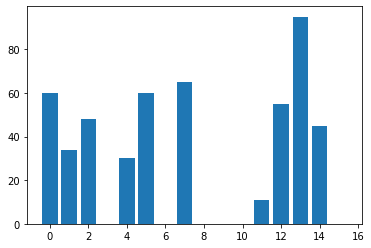

0 95


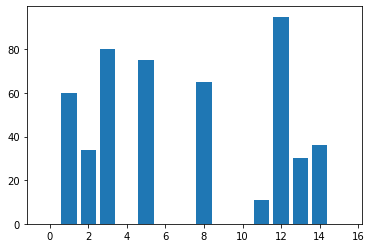

0 80


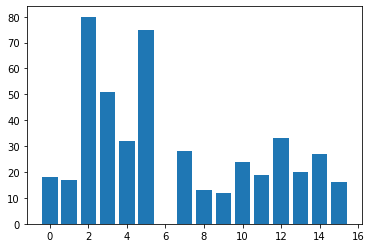

0 100


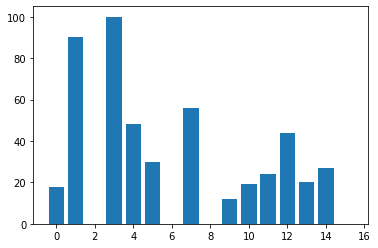

0 80


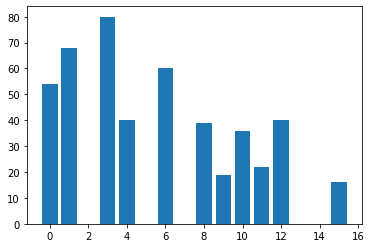

0 95


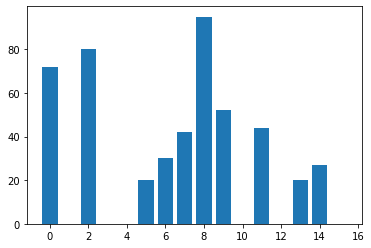

0 85


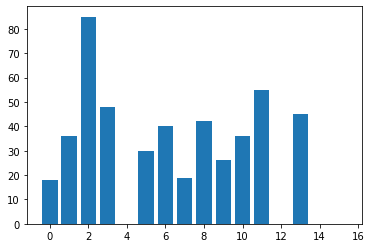

0 95


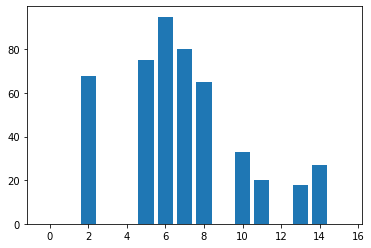

0 64


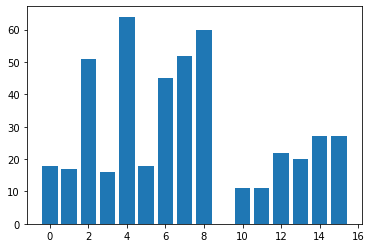

0 80


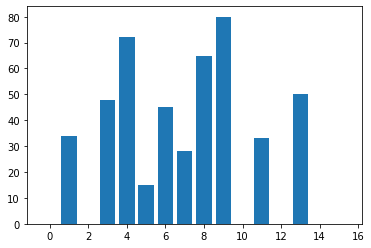

0 80


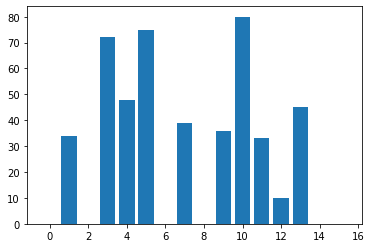

0 72


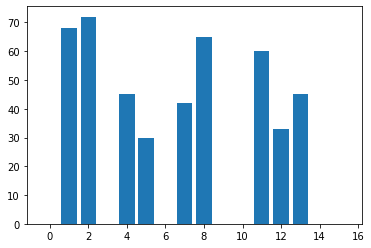

0 90


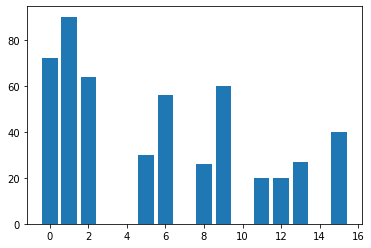

0 274


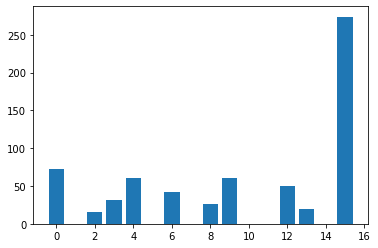

0 70


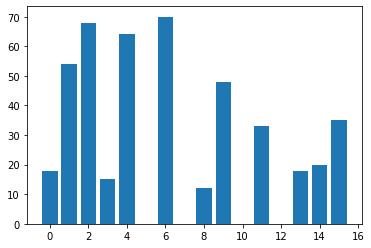

0 60


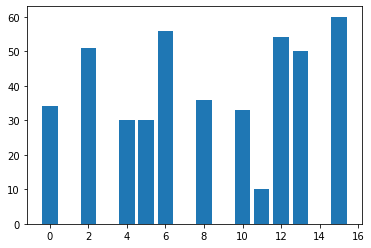

0 85


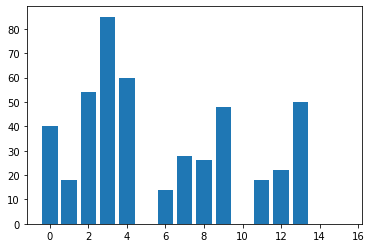

0 100


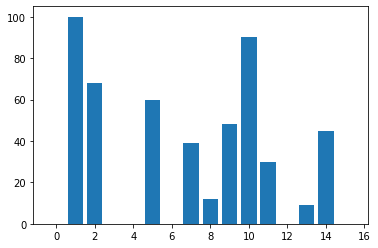

0 90


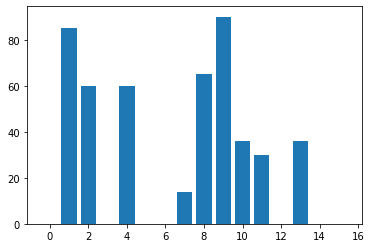

0 85


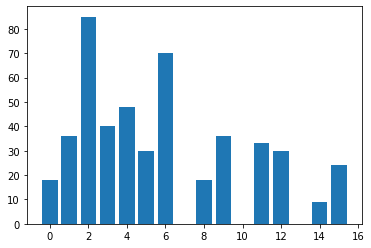

0 80


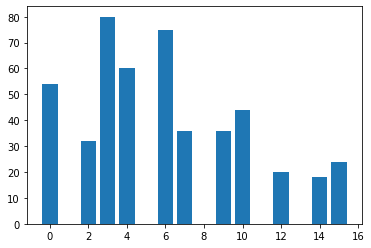

0 100


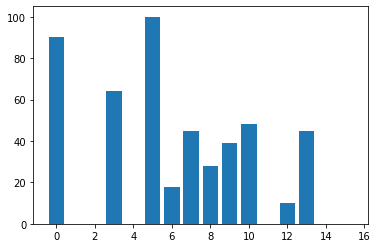

0 90


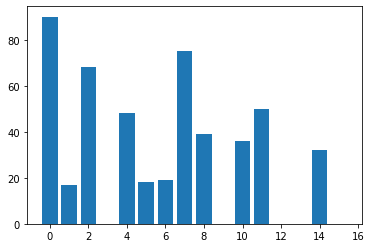

0 80


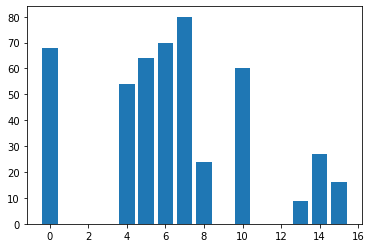

0 90


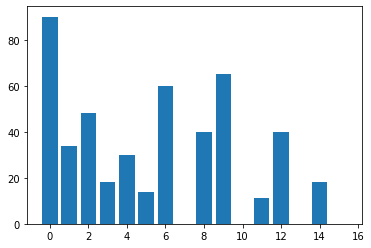

0 80


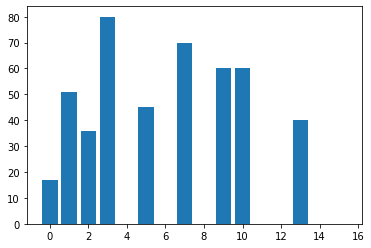

0 90


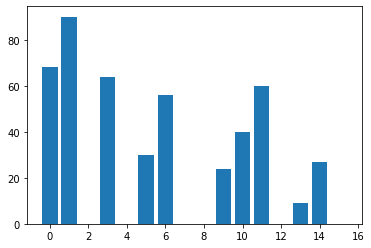

0 72


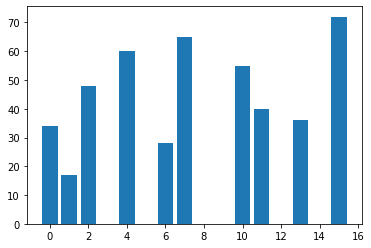

0 76


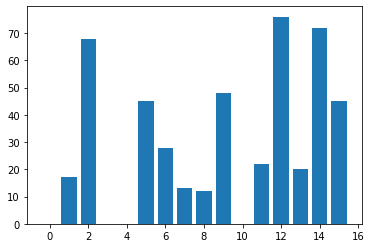

In [21]:
# let's see why pool 29 have the highest number of servers and still the weakest one:
for i in range(number_pools):
    guaranteed_capacity_map_ = guaranteed_capacity_map(i)
    print(min(list(guaranteed_capacity_map_.values())), max(list(guaranteed_capacity_map_.values())))
    plt.bar(list(guaranteed_capacity_map_.keys()), list(guaranteed_capacity_map_.values()))
    plt.show()

### we see in this graph that the servers are not well distributed, so i'm going to remedy that 

# Useful functions

In [24]:
# get the index of the servers of a pool on a giving row
def get_servers_index(pool_indexx, row_indexx):
    pool_servers_index = pools[pool_indexx]
    pool_row_servers_index = []
    # look for servers on that row 
    result_server_items = list(result_server.items())
    
    result_server_items = np.array([result_server_items[i] for i in range(len(result_server_items)) if result_server_items[i][1]!=None])
    
    ttt = np.array([result_server_items[i][1][0] for i in range(len (result_server_items))])  # getting the rows 
    
    servers_index = result_server_items[np.where(ttt == row_indexx)][:,0]  # index of the servers on that row
    for x in servers_index:
        if x in pool_servers_index:
            pool_row_servers_index.append(x)
    return pool_row_servers_index

# we also need a function to sort servers based on their capacity 
def sort_capacity(servers_list):
    capacities_map = {}
    for x in servers_list:
        capacities_map[x] = servers[x][1] # getting the cpacities of the servers
    return capacities_map

# a function to sort pools based on the guaranteed capacity
def sort_pools():
    pools_capacity = [(pool_index, guaranteed_capacity(pool_index)) for pool_index in range(number_pools)]
    return sorted(pools_capacity , key = lambda x:x[1])

# a function to find the weakest row of a pool
def weakest_row_pool(pool_index):
    pool_map = guaranteed_capacity_map(pool_index) #a dictionnary map that will help us to find the weakest row of that pool
    pool_map = sorted(list(pool_map.items()) , key = lambda x:x[1])  # sorting the map according to the capacity per row
    return pool_map[0][0]  # return the index of the row

# a function to calculate the guaranteed capcity based on a guaranteed_capacity_map
def guaranteed_cap_from_map (map_):
    return sum(list(map_.values())) - max(list(map_.values()))

def strongest_row_pool(pool_index):
    guaranteed_capacity_map_ = guaranteed_capacity_map(pool_index)  # getting the capcity map over the rows 
    sorted_map = sorted(list(guaranteed_capacity_map_.items()), key = lambda x:x[1], reverse= True) #sorting the map according to the capacity per row
    strongest_row = sorted_map[0][0] # the strongest row
    return strongest_row

In [25]:
# A function to find  the capacity and the row index of a server 
def find_cap_row (server_index):
    cap = servers[server_index][1]
    roww = result_server[server_index][0]
    return cap, roww

In [26]:
# go through each pool, and look for it's strongest row then give some of it to a row of the weakest pool if it is possible
def pools_exchange():
    for pool_index in range(number_pools):
        strongest_row = strongest_row_pool(pool_index)  # strongest row on that pool 
        # getting the servers of that pool on that row
        #print(pool_index, strongest_row)
        servers_index = get_servers_index(pool_index, strongest_row)
        # Now let's try to take the weakest server away and see what's gonna happen
        old_capacity = guaranteed_capacity(pool_index)
        
        new_map = guaranteed_capacity_map(pool_index)
        #print(new_map)
        new_map [strongest_row] = new_map [strongest_row] - servers[servers_index[0]][1]
        
        # new capacity
        new_capacity = guaranteed_cap_from_map(new_map)

        if new_capacity < old_capacity:
            continue
        else:
            #print('yes')
            # we will try to insert this server to another weak pool
            sorted_pools = sort_pools() # a list of sorted tuples of pool_index and guaranteed capacity 
            
            for i in range(len(sorted_pools)):
                current_pool = sorted_pools[i][0]
                if current_pool != pool_index:
                    # we will try to add that server to this pool
                    old_cap = guaranteed_capacity(current_pool)
                    new_map_ = guaranteed_capacity_map(current_pool)
                    new_map_ [strongest_row] = new_map_ [strongest_row] + servers[servers_index[0]][1]  # add this server to this pool
                    new_cap = guaranteed_cap_from_map(new_map_)
                    if new_cap > old_cap: # then do the changes
                        #print('here')
                        pools[pool_index].remove(servers_index[0])  # removing the server from the old pool
                        pools[current_pool].append(servers_index[0])      # adding it to the new pool
                        # updating result_server
                        t = list(result_server[servers_index[0]])
                        t[-1] = current_pool
                        result_server[servers_index[0]] = tuple(t)
                        break
                    
                        
        

In [27]:
for i in range(100):
    pools_exchange()

yes
here
yes
here
yes
here
yes
here
yes
here
yes
here


C:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


yes
here
yes
here
yes
here
yes
here


# Now let's see the capacity of the pools

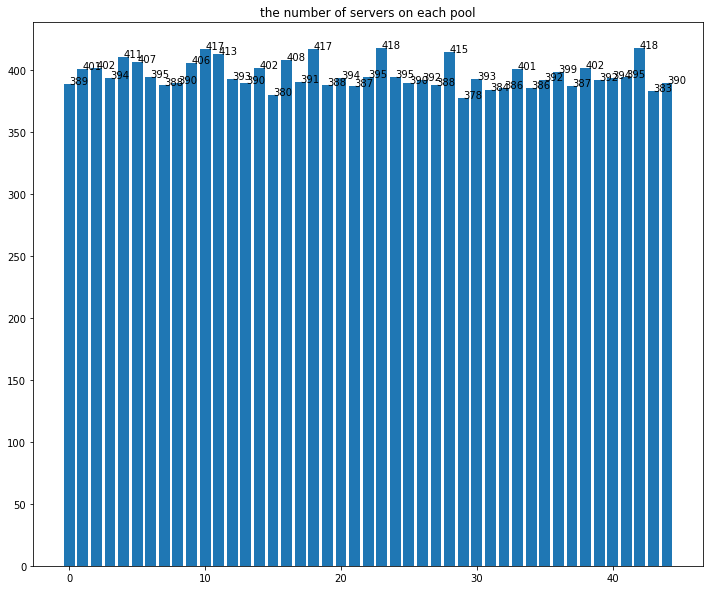

In [28]:
# the guaranteed capacity of each pool
plt.figure(figsize= (12,10))
plt.bar(list(pools.keys()), [guaranteed_capacity(i) for i in pools.keys()])
plt.title('the number of servers on each pool')
for j in range(len(list(pools.keys()))):
    plt.text(j, guaranteed_capacity(j) , guaranteed_capacity(j))

# There is a problem with pool number 29

In [30]:
guaranteed_capacity(23)  # best pool 

418

In [45]:
guaranteed_capacity_map(23)

{0: 0,
 1: 0,
 2: 68,
 3: 0,
 4: 0,
 5: 75,
 6: 95,
 7: 80,
 8: 65,
 9: 0,
 10: 33,
 11: 20,
 12: 0,
 13: 0,
 14: 27,
 15: 32}

In [31]:
guaranteed_capacity_map(29)  # worst pool

{0: 72,
 1: 0,
 2: 16,
 3: 32,
 4: 60,
 5: 0,
 6: 42,
 7: 0,
 8: 26,
 9: 60,
 10: 0,
 11: 0,
 12: 50,
 13: 20,
 14: 0,
 15: 90}

# We see that we can take the server of the pool 23 on the row 13 and associate it to the pool 29

In [33]:
# First thing first let's get the index of that server 
row_index = 13
pool_maker = 23
pool_taker = 29
server_index = get_servers_index(pool_maker, row_index)[0]
print(server_index)

676


C:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [34]:
# Now we make the  exchange 

pools[pool_maker].remove(server_index)  # removing the server from the old pool
pools[pool_taker].append(server_index)      # adding it to the new pool
# updating result_server
t = list(result_server[server_index])
t[-1] = pool_taker
result_server[server_index] = tuple(t)

In [48]:
print('the new guaranteed capacity is :' ,guaranteed_capacity(weakest_pool_finder()))

the new garanteed capacity is : 380


# Concluion: 
* We believe that with further optimization steps we can achieve better guaranteed capacities.